# Concrete Crack Detection using Convolutional Neural Networks

## Table of Contents
1. [Import Libraries](#import-libraries)
2. [Configuration & Hyperparameters](#configuration--hyperparameters)
3. [Data Exploration](#data-exploration)
4. [Sample Image Visualization](#sample-image-visualization)
5. [Data Loading & Preprocessing](#data-loading--preprocessing)
6. [Model Architecture](#model-architecture)
7. [Model Compilation](#model-compilation)
8. [Model Training](#model-training)
9. [Model Evaluation](#model-evaluation)
10. [Confusion Matrix Visualtion](#confusion-matrix-visualization)

----

## Import Libraries

In [ ]:
# Core libraries
import os
import pathlib
import cv2
import numpy as np
import pandas as pd
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sn

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


## Configuration & Hyperparameters

In [107]:
# Configuration class for parameter management
class Config:
    # Data path
    data_dir_path = '.\\datasets\\Concrete_Images'

    # Training parameters
    epochs = 5
    learning_rate = 0.001

    dropout_rate  = 0.5


config = Config()

## Data Exploration

In [87]:
# Data exploration
data_dir = pathlib.Path(config.data_dir_path)

# Count images in each class
positive_images = list(data_dir.glob('Positive/*'))
negative_images = list(data_dir.glob('Negative/*'))

print(f"Dataset Statistics:")
print(f"Positive (Crack) images: {len(positive_images)}")
print(f"Negative (No Crack) images: {len(negative_images)}")
print(f"Total images: {len(positive_images) + len(negative_images)}")


Dataset Statistics:
Positive (Crack) images: 20000
Negative (No Crack) images: 20000
Total images: 40000


## Sample Image Visualization

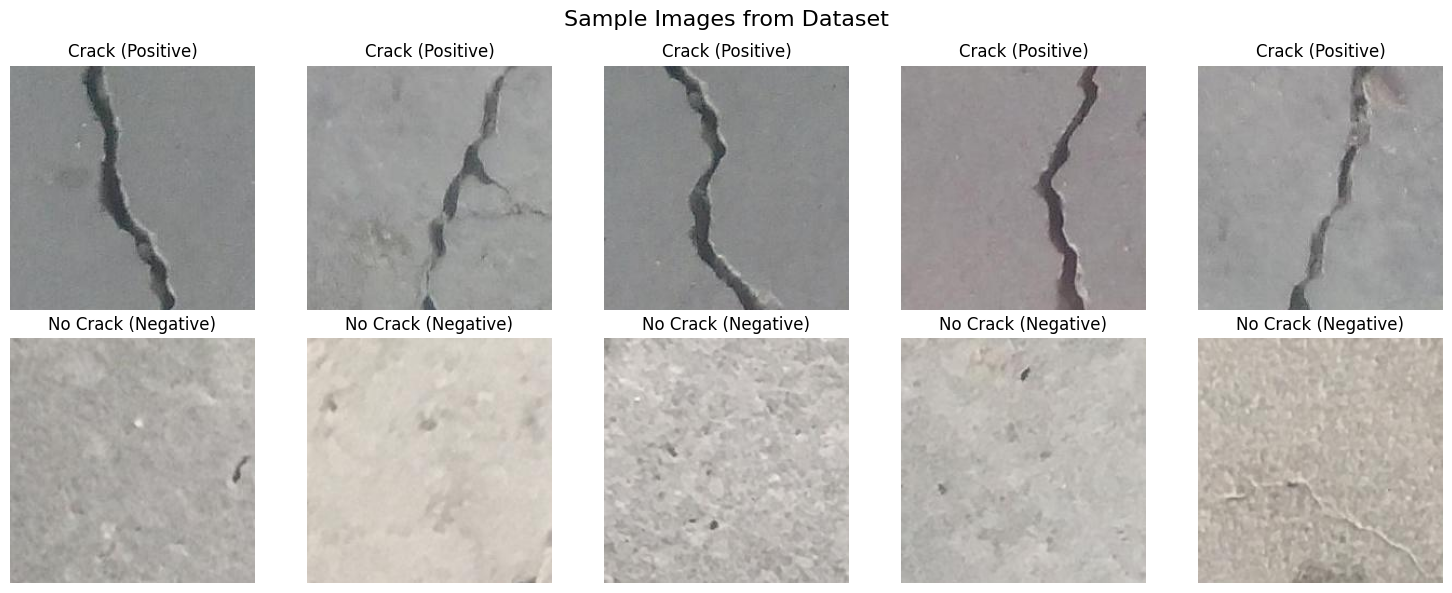

In [88]:
def display_sample_images(positive, negative, samples = 5):
    fig, axes = plt.subplots(2, samples, figsize=(15, 6))

    # Display positive samples
    for i in range(samples):
        img = Image.open(positive[i])
        axes[0, i].imshow(img)
        axes[0, i].set_title('Crack (Positive)')
        axes[0, i].axis('off')

    # Display negative samples
    for i in range(samples):
        img = Image.open(negative[i])
        axes[1, i].imshow(img)
        axes[1, i].set_title('No Crack (Negative)')
        axes[1, i].axis('off')


    plt.suptitle('Sample Images from Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

display_sample_images(positive_images, negative_images)

## Data Loading & Preprocessing

In [ ]:
# Create dictionaries to organize image data by class
crack_images_dict = {
    'negative' : negative_images,
    'positive' : positive_images, 
}

In [ ]:
# Define numerical labels for each class
crack_labels_dict = {
    'negative' : 0, 
    'positive' : 1, 
}

In [ ]:
# Initialize empty lists to store processed images and labels
X, y = [], []

# Process all images: load, resize, and assign labels
for crack_status, images in crack_images_dict.items():
    for image in images:
        # Load image using OpenCV
        img = cv2.imread(str(image))

        # Resize all images to consistent 100x100 pixels
        # This ensures all inputs have same dimensions for neural network
        resized_img = cv2.resize(img, (100, 100))

        # Add processed image to feature list
        X.append(resized_img)

        # Add corresponding label (0 or 1) to target list
        y.append(crack_labels_dict[crack_status])

In [ ]:
# Convert Python lists to NumPy arrays for efficient computation
X = np.array(X)
y = np.array(y)

In [ ]:
# Split dataset into training and testing sets
# random_state=0 ensures reproducible splits
# Default split: 75% training, 25% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# Display shapes to verify data dimensions
print(X_train.shape)
print(X_test.shape)

(30000, 100, 100, 3)
(10000, 100, 100, 3)


In [ ]:
# Normalize pixel values from 0-255 range to 0-1 range
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [ ]:
# Normalized data shape
print(X_train_scaled.shape)

(30000, 100, 100, 3)


## Model Architecture

In [ ]:
# Create Convolutional Neural Network using Sequential API
cnn_model = models.Sequential([
    
    # First Convolutional Block
    # Conv2D: Detects basic features like edges and textures
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Fourth Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    
    # Dense (Fully Connected) layers for final classification
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(config.dropout_rate),
    layers.Dense(256, activation='relu'),
    layers.Dropout(config.dropout_rate),
    
    # Output layer: Single neuron for binary classification
    layers.Dense(1, activation='sigmoid', name='predictions')
])
    

## Model Compilation

In [ ]:
# Function to compile model with specified optimizer and metrics
def compile_model(model, learning_rate=config.learning_rate):
    # Adam optimizer: Adaptive learning rate algorithm
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999
    )
    
    # Configure model for training
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

# Apply compilation settings to our CNN model
cnn_model = compile_model(cnn_model)

## Model Training

In [ ]:
print("Training Custom CNN...")

# Train the model on scaled training data
cnn_model.fit(
    X_train_scaled,
    y_train,
    epochs=config.epochs
)

print("Custom CNN training completed")

Training Custom CNN...
Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 200s 209ms/step - accuracy: 0.9702 - loss: 0.0974 - precision: 0.9725 - recall: 0.9667
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 189s 201ms/step - accuracy: 0.9936 - loss: 0.0235 - precision: 0.9941 - recall: 0.9931
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 188s 200ms/step - accuracy: 0.9945 - loss: 0.0211 - precision: 0.9944 - recall: 0.9946
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 187s 200ms/step - accuracy: 0.9955 - loss: 0.0161 - precision: 0.9950 - recall: 0.9960
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 194s 207ms/step - accuracy: 0.9950 - loss: 0.0171 - precision: 0.9949 - recall: 0.9951
Custom CNN training completed


## Model Evaluation

In [ ]:
# Evaluate model performance on test set
cnn_model.evaluate(X_test_scaled, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9896 - loss: 0.0318 - precision: 0.9800 - recall: 0.9996


[0.03502020612359047,
 0.9882000088691711,
 0.9772549271583557,
 0.9995988607406616]

In [ ]:
# Generate predictions on test set
y_pred = cnn_model.predict(X_test_scaled)
# Display first few predictions
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step


array([[3.9140641e-08],
       [4.8149686e-05],
       [3.4998400e-09],
       ...,
       [1.6860751e-08],
       [4.2061005e-03],
       [3.3864350e-08]], dtype=float32)

In [ ]:
# Convert probabilities to binary predictions
yp = []
for element in y_pred:
    if element > 0.5:
        yp.append(1)
    else:
        yp.append(0)

In [ ]:
# Display first 5 predictions
yp[:5]

[0, 0, 0, 0, 1]

In [ ]:
# Display actual labels for comparison
y_test[:5]

array([0, 0, 0, 0, 1])

In [ ]:
# Generate detailed classification report
print(classification_report(y_test, yp))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5014
           1       0.98      1.00      0.99      4986

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Confusion Matrix Visualization

Text(95.72222222222221, 0.5, 'Truth')

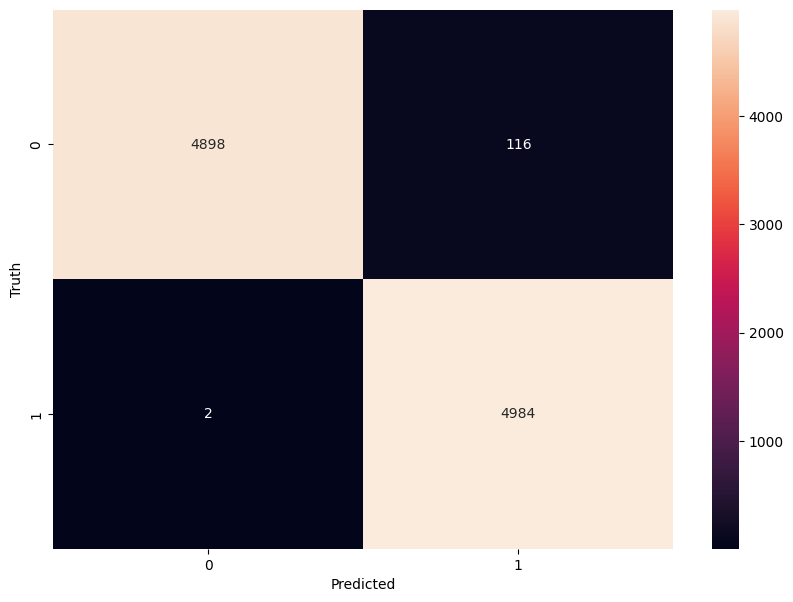

In [ ]:
# Create confusion matrix to visualize prediction accuracy
cm = tf.math.confusion_matrix(labels=y_test, predictions=yp)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Confusion Matrix Interpretation:
# Top-left: True Negatives (correctly predicted no crack)
# Top-right: False Positives (incorrectly predicted crack)
# Bottom-left: False Negatives (missed actual cracks)
# Bottom-right: True Positives (correctly predicted crack)